In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import zipfile
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

In [2]:
zf = zipfile.ZipFile('C:/Users/Serueja/Downloads/store-sales-time-series-forecasting.zip')
hol = pd.read_csv(zf.open('holidays_events.csv'),   parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')
oil = pd.read_csv(zf.open('oil.csv'), parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')
sample_submission = pd.read_csv(zf.open('sample_submission.csv'))
stores = pd.read_csv(zf.open('stores.csv'))
test = pd.read_csv(zf.open('test.csv'), index_col='date', parse_dates=['date'])
train = pd.read_csv(zf.open('train.csv'), parse_dates= ['date'], infer_datetime_format = True, dtype = {'store_nbr' : 'category', 'family' : 'category'}, usecols = ['date', 'store_nbr', 'family', 'sales'])
transactions = pd.read_csv(zf.open('transactions.csv'), index_col='date', parse_dates=['date'])
oil = oil.fillna(method='ffill')
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()

In [3]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)

In [4]:
calendar.head()

,avg_oil
2013-01-10,93.218571
2013-01-11,93.284286
2013-01-12,93.284286
2013-01-13,93.284286
2013-01-14,93.470000


In [5]:
hol = hol[hol.locale == 'National'] 
hol = hol.groupby(hol.index).first() 
hol.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


In [6]:
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags_{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
calendar.head()

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3
2013-01-13,93.284286,93.284286,93.284286,93.218571
2013-01-14,93.470000,93.284286,93.284286,93.284286
2013-01-15,93.490000,93.470000,93.284286,93.284286
2013-01-16,93.644286,93.490000,93.470000,93.284286
2013-01-17,93.970000,93.644286,93.490000,93.470000


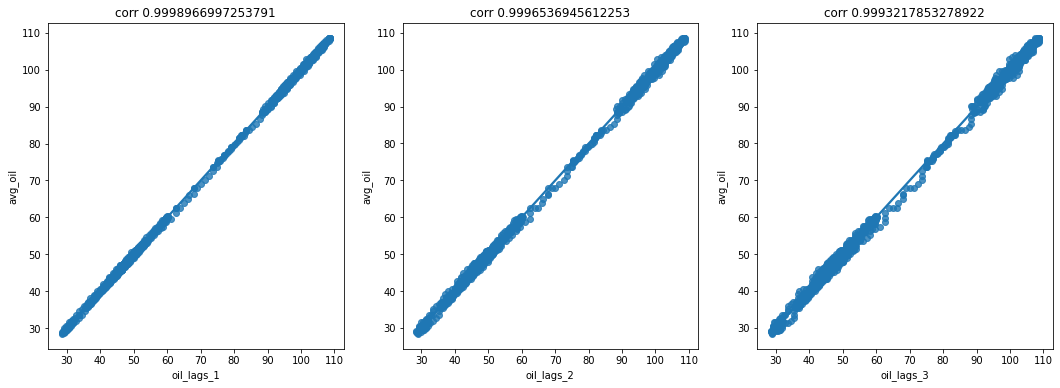

In [7]:
lag1, lag2, lag3 = 'oil_lags_1', 'oil_lags_2', 'oil_lags_3'

fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.regplot(x = calendar[lag1], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag1])}')
plt.subplot(1,3,2)
sns.regplot(x = calendar[lag2], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag2])}')
plt.subplot(1,3,3)
sns.regplot(x = calendar[lag3], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag3])}');

In [8]:
y = train.unstack(['store_nbr', 'family']).loc['2013':'2017']

In [9]:
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

                                                 ...                     \
store_nbr                                        ...         9            
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES    MEATS   
date                                             ...                      
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0    0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  374.531   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  400.863   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  310.878   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  447.685   

                                                                        \
store_nbr                                                                
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2013-01-01           0.0          0.0                     0.0    0.000   
2013-01-02         482.0          0.0                     0.0  651.292   
2013-01-03         372.0          0.0                     0.0  509.496   
2013-01-04         324.0          0.0                     0.0  332.672   
2013-01-05         461.0          0.0                     0.0  510.919   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0   0.000  
2013-01-02           83.0     0.0                        0.0  29.214  
2013-01-03           66.0     0.0                        0.0  25.000  
2013-01-04           57.0     0.0                        0.0  11.000  
2013-01-05           84.0     0.0                        0.0  28.361  

[5 rows x 1782 columns]

In [10]:
calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1

In [11]:
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not workday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday

In [12]:
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a workday
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a workday

In [13]:
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday

In [14]:
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns   

c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


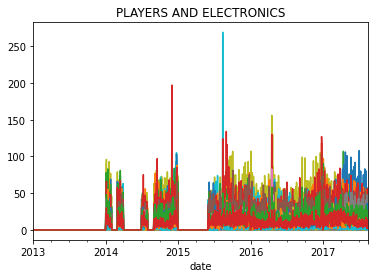

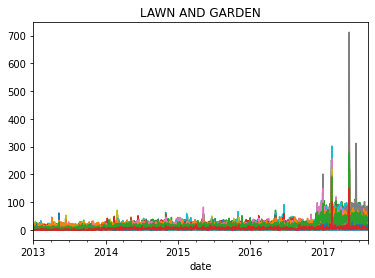

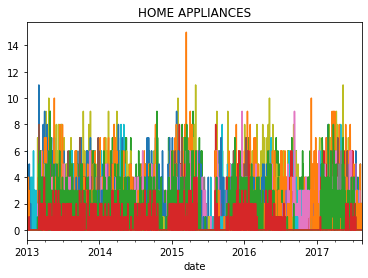

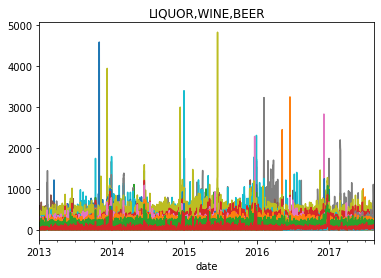

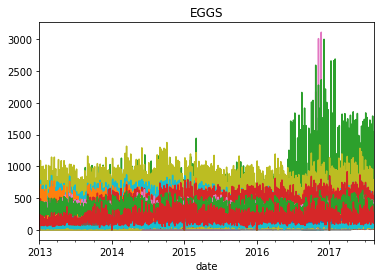

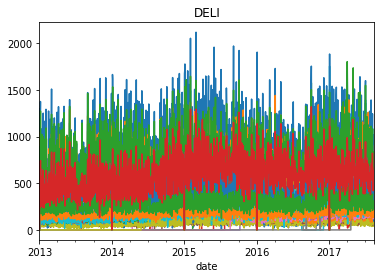

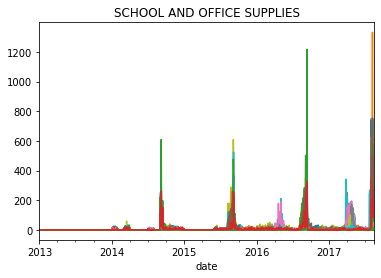

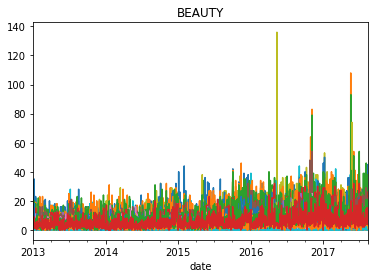

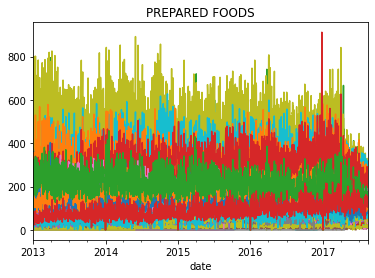

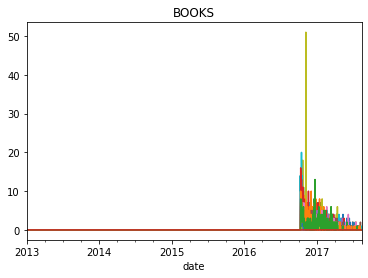

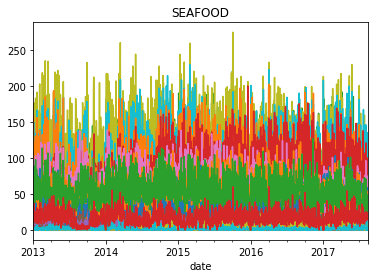

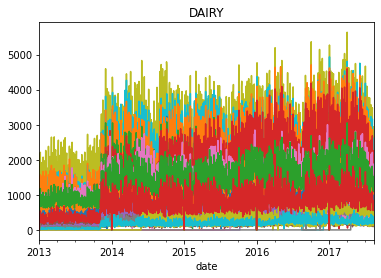

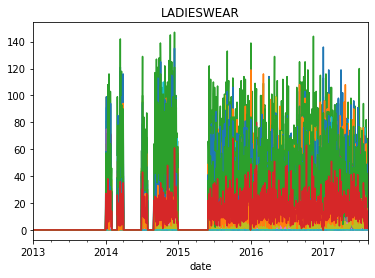

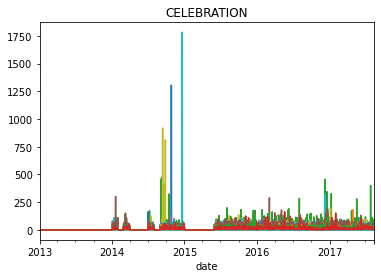

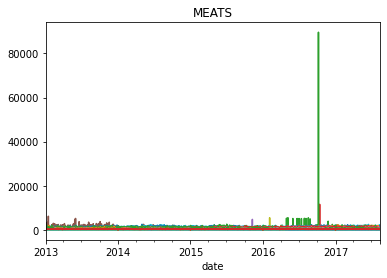

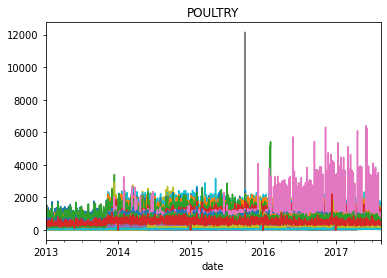

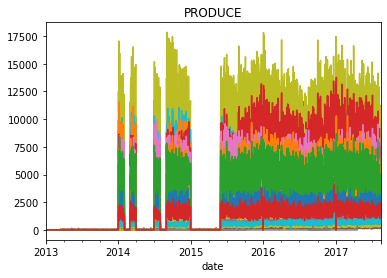

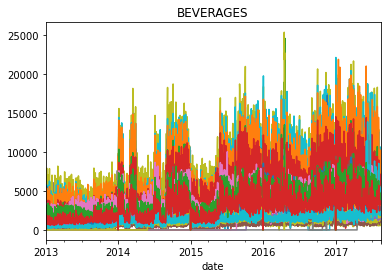

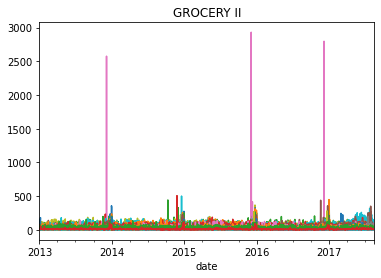

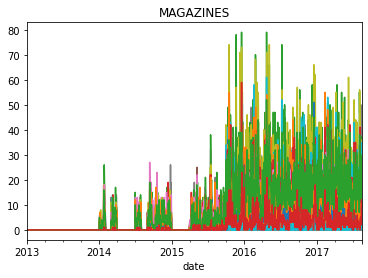

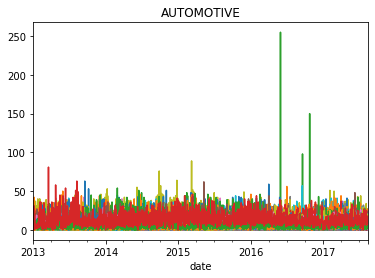

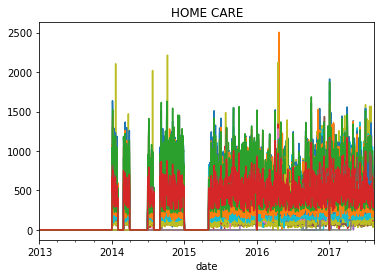

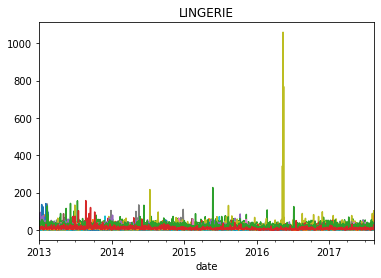

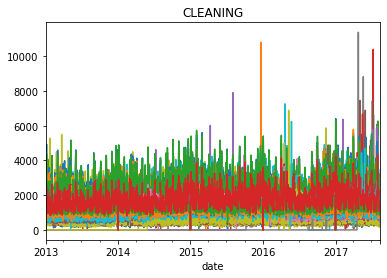

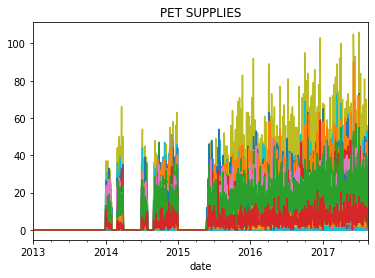

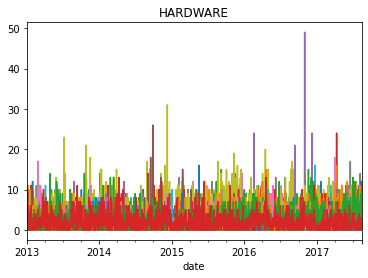

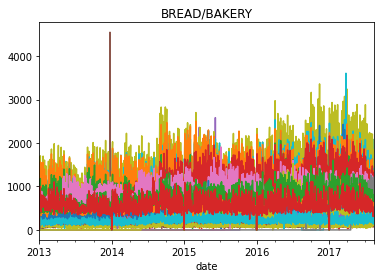

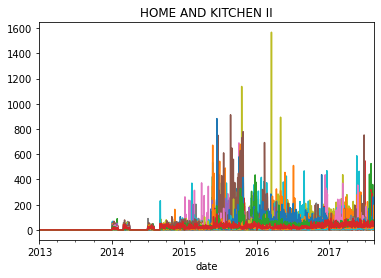

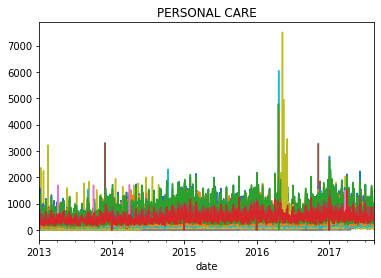

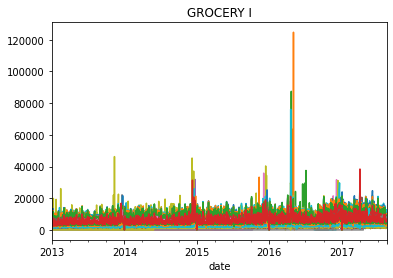

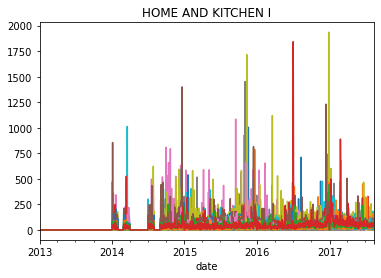

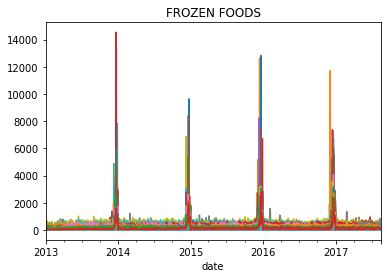

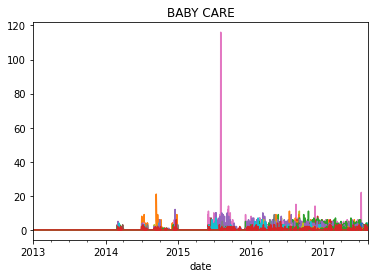

In [15]:
y = train.unstack(['store_nbr', 'family']).loc['2013':'2017']
family = {c[2] for c in train.index}
for f in family :
    ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
    ax.set_title(f)

In [16]:
sdate = '2017-04-30' 
edate = '2017-08-15'

In [17]:
school_season = [] 
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season
calendar.head()

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
y = train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq = 'W', order = 3)
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.358571,49.358571,49.358571,...,0,0,1,0,0,0,0,0,0,1
2017-05-01,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.154286,49.358571,49.358571,...,0,0,0,0,0,0,1,0,0,1
2017-05-02,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,48.870000,49.154286,49.358571,...,0,0,0,0,0,0,0,0,0,1
2017-05-03,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.711429,48.870000,49.154286,...,0,0,0,0,0,0,0,0,0,1
2017-05-04,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,48.187143,48.711429,48.870000,...,0,0,0,0,0,0,0,0,0,1


In [19]:
x_test = dp.out_of_sample(steps = 16)
x_test = x_test.join(calendar)
x_test.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2017-08-16,109.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,48.648571,48.934286,...,0,0,0,0,0,0,0,0,0,1
2017-08-17,110.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,48.281429,48.648571,...,0,0,0,0,0,0,0,0,0,1
2017-08-18,111.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,47.995714,48.281429,...,1,0,0,0,0,0,0,0,0,1
2017-08-19,112.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.852857,47.852857,47.995714,...,0,1,0,0,0,0,0,0,0,1
2017-08-20,113.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.852857,47.852857,47.852857,...,0,0,1,0,0,0,0,0,0,1


In [20]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error as mae

c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
lnr = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
lnr.fit(x, y)

yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)

svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(x, y)

c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


MultiOutputRegressor(estimator=SVR(C=0.2), n_jobs=-1)

In [22]:
yfit_svr = pd.DataFrame(svr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)

In [23]:
yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = x.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = x_test.index, columns = y.columns).clip(0.)

In [24]:
y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

In [25]:
print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)),'\n')

print('LNR MAE :', mae(y, yfit_lnr))
print('SVR MAE :', mae(y, yfit_svr))
print('Mean MAE :', mae(y, yfit_mean))

LNR RMSLE : 0.39723741700799337
SVR RMSLE : 0.46277177754046106
Mean RMSLE : 0.38552727864877173 

LNR MAE : 53.62524384854435
SVR MAE : 106.34957461347354
Mean MAE : 70.9419715673951


In [26]:
ymean = yfit_lnr.append(ypred_lnr)
school = ymean.loc(axis = 1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES']
ymean = ymean.join(school.shift(1), rsuffix = 'lag1') # I'm also adding school lag for its yearly cycle.

C:\Users\Serueja\AppData\Local\Temp\ipykernel_22464\3484369143.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ymean = yfit_lnr.append(ypred_lnr)


In [27]:
x = x.loc['2017-05-01':]
x = x.join(ymean) # Concatenating linear result
x_test = x_test.join(ymean)
y = y.loc['2017-05-01':]

C:\Users\Serueja\AppData\Local\Temp\ipykernel_22464\1770683367.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  x = x.join(ymean) # Concatenating linear result
C:\Users\Serueja\AppData\Local\Temp\ipykernel_22464\1770683367.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  x_test = x_test.join(ymean)


In [28]:
x.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,"(saleslag1, 5, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 50, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 51, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 52, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 53, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 54, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 6, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 7, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 8, SCHOOL AND OFFICE SUPPLIES)","(saleslag1, 9, SCHOOL AND OFFICE SUPPLIES)"
date,,,,,,,,,,,,,,,,,,,,,
2017-05-01,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.154286,49.358571,49.358571,...,5.681186,12.386162,39.308378,35.735047,3.504591,4.458365,0.0,2.898127e-01,1.362256e+00,5.888185
2017-05-02,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,48.870000,49.154286,49.358571,...,8.000000,21.000000,140.000000,143.000000,6.000000,24.000000,0.0,8.881784e-16,7.105427e-15,1.000000
2017-05-03,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.711429,48.870000,49.154286,...,4.006815,0.000000,25.568410,22.443601,3.233998,2.924720,0.0,9.287580e-01,6.544045e-01,0.000000
2017-05-04,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,48.187143,48.711429,48.870000,...,3.774796,18.818755,31.758404,26.396299,2.222980,4.187333,0.0,5.372967e-01,7.127819e-01,0.000000
2017-05-05,6.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.760000,48.187143,48.711429,...,3.792575,32.369731,27.799869,22.187040,2.513475,4.438171,0.0,6.964441e-01,9.101601e-01,16.477152
